## Segunda vuelta

In [1]:
# Se importan las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import dirichlet, gamma

In [2]:
# Se guarda el documento Excel a utilizar, contiene los datos de las elecciones.
# En particular, se usa la hoja llamada "Datos_por_dia_2v" del Excel "Datos_2vuelta".
df2 = pd.read_excel('Datos_2vuelta.xlsx', sheet_name='Datos_por_dia_2v')
print(df2)

# Se guardan los datos de la segunda vuelta de ambos candidatos,
# lo cual es desde el 16 de septiembre de 2021 hasta el 19 de diciembre de 2021.
datos2vuelta = df2.to_numpy()[:, 2:]
datos2vuelta = np.array(datos2vuelta, dtype=int)

        Fecha    N  Nkast  Nboric
0  2021-09-16  709    191     355
1  2021-09-17    0      0       0
2  2021-09-18    0      0       0
3  2021-09-19    0      0       0
4  2021-09-20    0      0       0
..        ...  ...    ...     ...
91 2021-12-15    0      0       0
92 2021-12-16    0      0       0
93 2021-12-17    0      0       0
94 2021-12-18    0      0       0
95 2021-12-19    0      0       0

[96 rows x 4 columns]


### Modelo 1:
Distribución de prueba: $Gamma(500\times\alpha_{ti}+y_{ti}, 1)$

In [3]:
# Se define el modelo para analizar los datos, basado en la distribución Gamma y la distribución Dirichlet.
# Recibe como parámetros los datos "data" y la cantidad de iteraciones "N".
def modelo1(data, N):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha)
    prueba = lambda alpha: np.array([gamma.rvs(a) for a in alpha])
    # Cantidad de días.
    days = np.size(data, 0)
    # Cantidad de candidatos.
    cand = np.size(data, 1)
    # Va a guardar las muestras generadas.
    muestra = np.zeros((N, days, cand))
    # Probabilidad a priori uniforme para cada candidato.
    prior = np.full(cand, 1/cand)
    c = np.zeros(days)
    for i in range(N):
        for day in range(days):
            if day == 0:
                p = prior 
            else:
                p = muestra[i, day-1]
            # Observaciones del día actual
            y = data[day]
            # Cálculo alpha
            alpha = y + 500 * p
            p_prueba = prueba(alpha)
            p_prueba = p_prueba / p_prueba.sum()
            # Metropolis-Hasting
            metrop = post(p_prueba, alpha) - post(p, alpha)
            if min(metrop, 0) > np.log(np.random.uniform()):
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p
    # Muestra generada y cantidad de aceptaciones por día.
    return muestra, c

In [4]:
# Parámetros a cambiar.
datos1 = datos2vuelta
iteraciones1 = 10_000

aceptados dia 1: 100.000000%
aceptados dia 2: 70.880000%
aceptados dia 3: 70.590000%
aceptados dia 4: 71.540000%
aceptados dia 5: 70.010000%
aceptados dia 6: 71.000000%
aceptados dia 7: 71.400000%
aceptados dia 8: 70.360000%
aceptados dia 9: 71.380000%
aceptados dia 10: 70.640000%
aceptados dia 11: 69.880000%
aceptados dia 12: 70.810000%
aceptados dia 13: 71.170000%
aceptados dia 14: 70.460000%
aceptados dia 15: 70.170000%
aceptados dia 16: 93.900000%
aceptados dia 17: 71.000000%
aceptados dia 18: 70.610000%
aceptados dia 19: 70.690000%
aceptados dia 20: 70.820000%
aceptados dia 21: 71.040000%
aceptados dia 22: 95.810000%
aceptados dia 23: 70.410000%
aceptados dia 24: 70.230000%
aceptados dia 25: 70.560000%
aceptados dia 26: 70.370000%
aceptados dia 27: 70.160000%
aceptados dia 28: 71.390000%
aceptados dia 29: 84.050000%
aceptados dia 30: 89.740000%
aceptados dia 31: 70.860000%
aceptados dia 32: 71.060000%
aceptados dia 33: 71.210000%
aceptados dia 34: 70.980000%
aceptados dia 35: 70.8

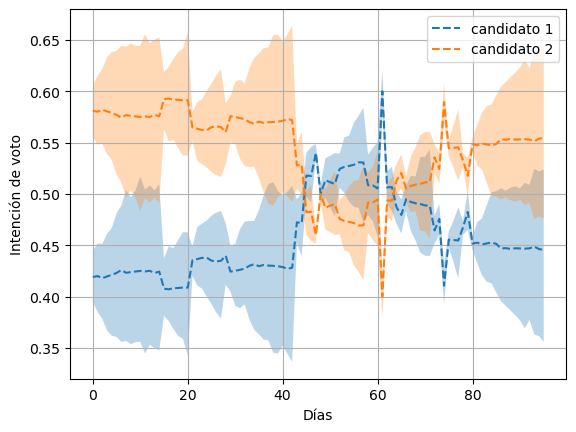

In [5]:
muestra1, c1 = modelo1(datos1, iteraciones1)
# Se reduce la muestra a un submuestreo.
muestra1 = muestra1[iteraciones1//10::100]

# Calcula el promedio para cada día del submuestreo.
prop = muestra1.mean(0)
# Se guarda como variable la cantidad de días.
days = np.size(prop, 0)
std = np.std(muestra1, axis=0)
# Intervalos de credibilidad 90%.
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra1, q, axis=0)
# Se plotea el porcentaje de aceptación por cada día.
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c1[i]/iteraciones1))

# Se grafica el porcentaje de aceptación por cada día y el intervalo de confianza.
for i in range(2):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend()

In [6]:
# Se usa el último día de la lista de los promedios.
pred = prop[-1]
# Se muestra el porcentaje estimado para cada candidato.
print('Kast: {:%}'.format(pred[0]))
print('Boric: {:%}'.format(pred[1]))

Kast: 44.544723%
Boric: 55.455277%


### Modelo 2:
Distribución de prueba: $Unif(\max\{(500\alpha_{t-1,i}+y_{ti})-d,0\},(500\alpha_{t-1,i}+y_{ti})+d)$

In [7]:
# Se define el segundo modelo para analizar los datos, basado en la distribución uniforme y la distribución Dirichlet.
# Recibe como parámetros los datos "data", la cantidad de iteraciones "N" y  rango alrededor del valor esperado "d".
def modelo2(data, N, d):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha)
    # Cantidad de días.
    days = np.size(data, axis=0)
    # Cantidad de candidatos.
    cand = np.size(data, axis=1)
    prueba = lambda alpha, d: np.random.randint(np.maximum(alpha-d,0),alpha+d, size=cand)
    # Va a guardar las muestras generadas.
    muestra = np.zeros((N, days, cand))
    # Probabilidad a priori uniforme para cada candidato.
    prior = np.full(cand, 1/cand)
    c = np.zeros(days)
    for i in range(N):
        for day in range(days):
            if day == 0:
                p = prior
            else:
                p = muestra[i, day-1]
            # Observaciones del día actual
            y = data[day]
            # Cálculo alpha
            alpha = 500 * p + y
            p_prueba = prueba(alpha, d)
            p_prueba = p_prueba/p_prueba.sum()
            if post(p_prueba, alpha) - post(p, alpha) > np.log(np.random.uniform()):
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p
    # Muestra generada y cantidad de aceptaciones por día.
    return muestra, c

In [8]:
# Parámetros a cambiar.
datos2 = datos2vuelta
iteraciones2 = 10_000
d = 50

aceptados dia 1: 100.000000%
aceptados dia 2: 43.560000%
aceptados dia 3: 43.620000%
aceptados dia 4: 44.170000%
aceptados dia 5: 44.170000%
aceptados dia 6: 44.360000%
aceptados dia 7: 43.970000%
aceptados dia 8: 43.170000%
aceptados dia 9: 43.610000%
aceptados dia 10: 43.740000%
aceptados dia 11: 44.540000%
aceptados dia 12: 43.800000%
aceptados dia 13: 42.820000%
aceptados dia 14: 43.910000%
aceptados dia 15: 44.050000%
aceptados dia 16: 95.190000%
aceptados dia 17: 42.570000%
aceptados dia 18: 43.570000%
aceptados dia 19: 43.930000%
aceptados dia 20: 43.760000%
aceptados dia 21: 42.370000%
aceptados dia 22: 98.340000%
aceptados dia 23: 44.540000%
aceptados dia 24: 44.470000%
aceptados dia 25: 44.700000%
aceptados dia 26: 44.780000%
aceptados dia 27: 44.430000%
aceptados dia 28: 45.010000%
aceptados dia 29: 73.770000%
aceptados dia 30: 89.480000%
aceptados dia 31: 44.800000%
aceptados dia 32: 44.280000%
aceptados dia 33: 43.950000%
aceptados dia 34: 43.370000%
aceptados dia 35: 44.0

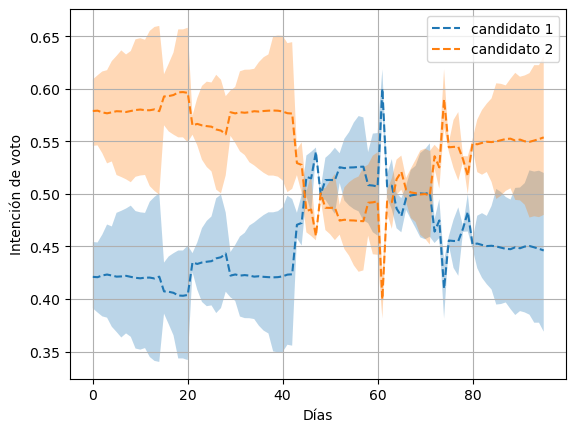

In [9]:
muestra2, c2 = modelo2(datos2, iteraciones2, d)
# Se reduce la muestra a un submuestreo.
muestra2 = muestra2[iteraciones2//10::100]

# Calcula el promedio para cada día del submuestreo.
prop = muestra2.mean(0)
# Se guarda como variable la cantidad de días.
days = np.size(prop, 0)
# Intervalos de credibilidad 90%.
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra2, q, axis=0)
# Se plotea el porcentaje de aceptación por cada día.
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c2[i]/10_000))
    
# Se grafica el porcentaje de aceptación por cada día y el intervalo de confianza.
for i in range(2):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [10]:
# Se usa el último día de la lista de los promedios.
pred = prop[-1]
# Se muestra el porcentaje estimado para cada candidato.
print('Kast: {:%}'.format(pred[0]))
print('Boric: {:%}'.format(pred[1]))

Kast: 44.618845%
Boric: 55.381155%
